# Sybil Detection

In [1]:
import os
import pandas as pd
import numpy as np

from avd.graph_learning_controller import GraphLearningController
from avd.learners.sklearner import SkLearner
from avd.configs import config
from avd.datasets.twitter import load_data

Specify output directory for classifiers.

In [2]:
output_folder = os.getcwd() + "/data/output"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Define what is considered positive and negative labels.

In [3]:
labels = {"neg": "Real", "pos": "Fake"}

We first load the Twitter graph.
load_data will return a graph object(twitter_graph) and a config object(twitter_config).

In [4]:
twitter_graph, twitter_config = load_data(dataset_file_name="twitter_filtered.csv", labels_file_name="twitter_labels_filtered.csv", 
                                          labels_map=labels, limit=5000000) # Loads filtered dataset.
print(len(twitter_graph.vertices))

Loading labels...
Loading graph...
Data loaded.
2320975


Some of the extracted feature can be useful for understanding the result, but they will not be used in the classification proccess.

In [5]:
if twitter_graph.is_directed:
    meta_data_cols = ["dst", "src", "out_degree_v", "in_degree_v", "out_degree_u", "in_degree_u"]
else:
    meta_data_cols = ["dst", "src", "number_of_friends_u", "number_of_friends_v"]

Finally, we train the classification algorithm.
The Twitter dataset is incomplete and missing a lot of data.
In order to deal with this problem, we train 10 times and aggregate the results.

In [6]:
#for i in range(10):
twitter_config._name = "twitter_" + "linksProbability_"# + str(i) + "_"
learner = SkLearner(labels=labels)
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path, 
                      test_size={"neg": 10000, "pos": 1000},
                      train_size={"neg": 20000, "pos": 20000}, 
                      meta_data_cols=meta_data_cols)

Setting training and test sets


  5%|▍         | 509/11000 [00:00<00:04, 2450.52feature/s]

Graph loaded


129934feature [00:50, 2550.64feature/s]                     
  0%|          | 114/40000 [00:00<00:35, 1136.95feature/s]

Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_linksProbability__test.csv
Graph loaded


100%|██████████| 40000/40000 [00:19<00:00, 2079.61feature/s]


Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_linksProbability__train.csv


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Training 10-fold validation: {'auc': 0.8702849374999999, 'recall': 0.9170999999999999, 'precision': 0.6999158148298315, 'accuracy': 0.761925, 'fpr': 0.39325, 'tnr': 0.60675}
Validate_prediction_by_links: {'auc': 1.0, 'recall': 0.3333333333333333, 'precision': 0.03529411764705882, 'accuracy': 0.9340329835082459, 'fpr': 0.061886792452830186}


In [7]:
def aggreagate_res(data_folder, res_path):
    results_frame = pd.DataFrame()
    for f in os.listdir(data_folder):
        temp_df = pd.read_csv(data_folder + "/" + f,index_col=0, encoding='utf-8', engine='python')
        results_frame = results_frame.append(temp_df)
    results_frame = results_frame.groupby("src_id").mean()

    return results_frame.reset_index()

In [8]:
df = aggreagate_res(output_folder, "res.csv").sort_values("mean_link_label", ascending=False)

In order to calculate precision at k, we add two additional columns:
1. The sum of the positive examples.
2. k  the total number of resutls until the specific row. (row number)

In [9]:
df["actual_sum"] = df["actual"].cumsum()
df["k"] = 1
df["k"] = df["k"].cumsum()

In [10]:
df.head(10)

,src_id,neg probability,edge number,pos probability,mean_link_label,sum_link_label,predicted_label,actual,actual_sum,k
3538,880719,0.338194,16.5,0.661806,1.000000,16.5,1.0,1.0,1.0,1
2488,352725,0.248462,13.5,0.751538,1.000000,13.5,1.0,0.5,1.5,2
3600,946314,0.215886,13.0,0.784114,1.000000,13.0,1.0,0.0,1.5,3
3965,2104351,0.244707,14.0,0.755293,0.966667,13.5,1.0,1.0,2.5,4
2905,496918,0.373933,12.0,0.626067,0.916667,11.0,1.0,1.0,3.5,5
1917,215522,0.397209,14.0,0.602791,0.857143,12.0,1.0,1.0,4.5,6
3844,1455795,0.262403,24.0,0.737597,0.854167,20.5,1.0,0.5,5.0,7
1916,215410,0.406307,12.5,0.593693,0.839744,10.5,1.0,1.0,6.0,8
3996,2424868,0.347374,22.0,0.652626,0.818182,18.0,1.0,0.0,6.0,9
1918,215624,0.427590,15.5,0.572410,0.806250,12.5,1.0,1.0,7.0,10


We add an additional column that stores the p@k values by calculating the precision at k.

In [11]:
df["p@k"] = df.apply(lambda x: x["actual_sum"]/x["k"], axis=1)

In [12]:
df[["k", "p@k"]].head(10)

,k,p@k
3538,1,1.000000
2488,2,0.750000
3600,3,0.500000
3965,4,0.625000
2905,5,0.700000
1917,6,0.750000
3844,7,0.714286
1916,8,0.750000
3996,9,0.666667
1918,10,0.700000


We can see in the p@k plot that the resuts are musch better then random which about 6%.

<Figure size 432x288 with 0 Axes>

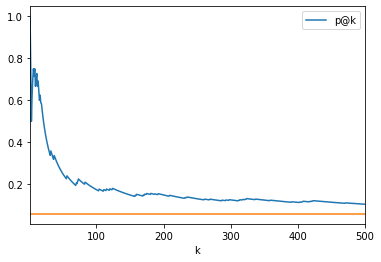

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
df[["k", "p@k"]][:500].plot(x="k", y= "p@k")
plt.plot(df[["k"]].values, np.full((len(df[["k"]]),1), 0.06))

In [14]:
twitter_config._name = "twitter_" + "LogisticRegression_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_logistic_regression_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 10000, "pos": 1000},
                        training_size={"neg": 20000, "pos": 20000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets


  1%|          | 98/11000 [00:00<00:11, 978.33feature/s]

Graph loaded


129934feature [00:45, 2877.04feature/s]                     
  1%|          | 263/40000 [00:00<00:31, 1246.27feature/s]

Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_LogisticRegression__test.csv
Graph loaded


100%|██████████| 40000/40000 [00:19<00:00, 2069.08feature/s]


Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_LogisticRegression__train.csv


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Training 10-fold validation: {'auc': 0.870844025, 'recall': 0.917, 'precision': 0.6994510080664766, 'accuracy': 0.7614500000000001, 'fpr': 0.3941, 'tnr': 0.6059}


In [15]:
twitter_config._name = "twitter_" + "RandomForest_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_randomforest_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 10000, "pos": 1000},
                        training_size={"neg": 20000, "pos": 20000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets


  3%|▎         | 345/11000 [00:00<00:09, 1093.41feature/s]

Graph loaded


129934feature [00:47, 2762.70feature/s]                     
  0%|          | 112/40000 [00:00<00:35, 1109.69feature/s]

Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_RandomForest__test.csv
Graph loaded


100%|██████████| 40000/40000 [00:18<00:00, 2121.12feature/s]


Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_RandomForest__train.csv


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Training 10-fold validation: {'auc': 0.8702307375, 'recall': 0.9148999999999999, 'precision': 0.6995645311242769, 'accuracy': 0.7609250000000001, 'fpr': 0.39304999999999995, 'tnr': 0.6069500000000001}


In [16]:
twitter_config._name = "twitter_" + "IsolationForest_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_isolation_forest_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 10000, "pos": 1000},
                        training_size={"neg": 20000, "pos": 20000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets


  3%|▎         | 331/11000 [00:00<00:09, 1086.58feature/s]

Graph loaded


129934feature [00:44, 2939.02feature/s]                     
  0%|          | 119/40000 [00:00<00:33, 1187.21feature/s]

Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_IsolationForest__test.csv
Graph loaded


100%|██████████| 40000/40000 [00:19<00:00, 2085.88feature/s]


Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_IsolationForest__train.csv


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Training 10-fold validation: {'auc': 0.8838678999999999, 'recall': 0.91525, 'precision': 0.7109863134557007, 'accuracy': 0.7712, 'fpr': 0.37285, 'tnr': 0.6271500000000001}
